no alignment : 0.000 seconds
 sum sq. error = 1239.2240714050795
affine : 0.004 seconds
 sum sq. error = 839.1542843960112
procrustes : 0.000 seconds
 sum sq. error = 272.6945484899542
cca : 0.011 seconds
 sum sq. error = 23.789130657412468
cca_v2 : 0.002 seconds
 sum sq. error = 266.97578596606957


/Users/tkn/Downloads/ManifoldWarping-master/python/alignment.py:65: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  self.pY = np.linalg.lstsq(Ytrain,Xtrain)[0][:,:num_dims]


linear manifold aln : 0.137 seconds
 sum sq. error = 245.15663817257695
ctw : 16.234 seconds
 sum sq. error = 290.590241380664
manifold warping : 5.336 seconds
 sum sq. error = 1166.0625483064523
dtw : 1.398 seconds
 sum sq. error = 0.15272649299408836
deep manifold aln : 0.442 seconds
 sum sq. error = 0.349157545883732
nonlinear manifold warp : 3.370 seconds
 sum sq. error = 481.02030231862307


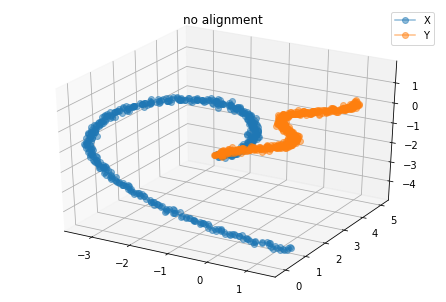

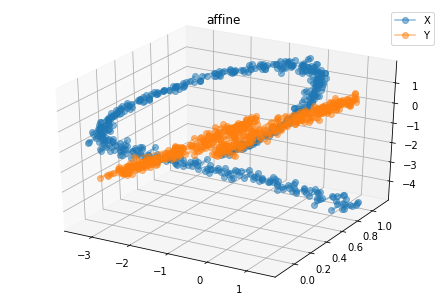

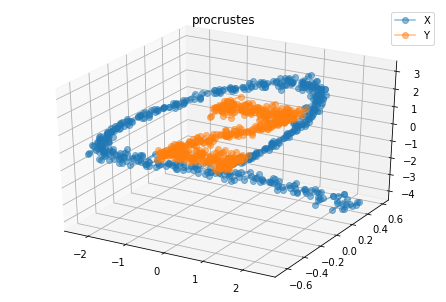

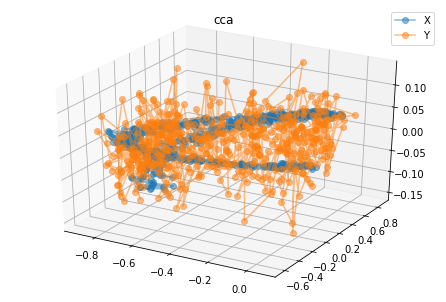

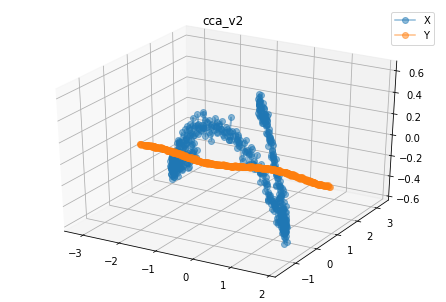

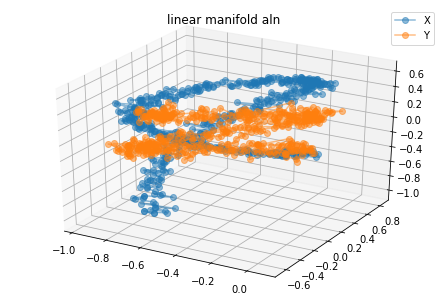

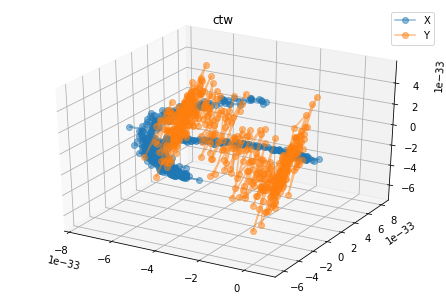

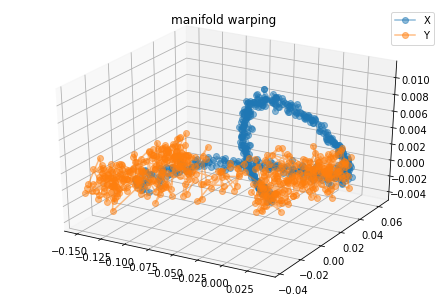

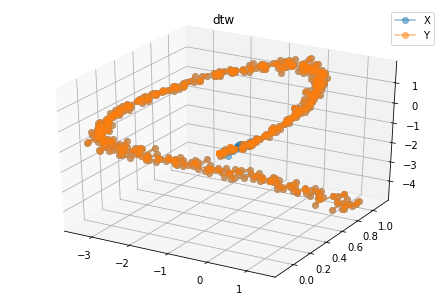

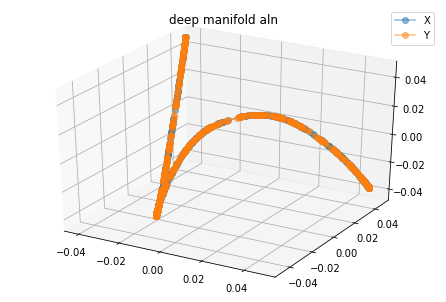

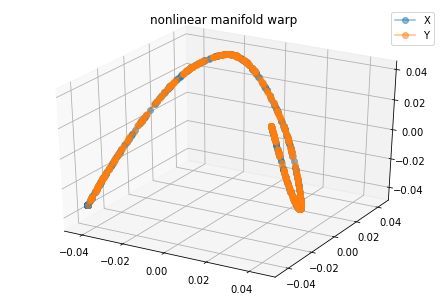

In [2]:
''' Example usage of the alignment methods in this directory:

  # get your two data sets somehow
  X,Y = gen_data(1000)

  # make correspondences and/or neighbor graphs
  corr = Correspondence(matrix=numpy.eye(1000))
  Wx = neighbor_graph(X,k=5)
  Wy = neighbor_graph(Y,k=5)

  # a linear projector:
  proj = Procrustes(X,Y,corr,2)  # for 2-d output
  Xnew, Ynew = proj.project(X,Y) # or any other data you want to project

  # a non-linear projector:
  Xnew,Ynew = manifold_nonlinear(X,Y,corr,2,Wx,Wy)

  # show the alignment:
  show_alignment(Xnew,Ynew,'nonlinear manifold aln')()
  # or just use normal pyplot functions
'''
import numpy as np
from matplotlib import pyplot

from alignment import (
    TrivialAlignment, Affine, Procrustes, CCA, CCAv2,
    ManifoldLinear, manifold_nonlinear)
from correspondence import Correspondence
from distance import SquaredL2
from neighborhood import neighbor_graph
from synthetic_data import swiss_roll, add_noise, spiral
from util import pairwise_error, Timer
from viz import show_alignment
from warping import (
    ctw, dtw, manifold_warping_linear, manifold_warping_nonlinear)


def gen_data(n, three_d=False):
  t = np.linspace(0,5,n)
  if three_d:
    X = swiss_roll(t,lambda A: np.sin(A)**2)
    Y = np.vstack((np.sin(t)**2,t,np.zeros(n))).T
  else:
    X = spiral(t)
    Y = X[:,(1,0)]  # swap x and y axes
  return add_noise(X,0.05), add_noise(Y,0.05)


if __name__ == '__main__':
  n = 500
  d = 3
  X, Y = gen_data(n, d == 3)
  corr = Correspondence(matrix=np.eye(n))
  Wx = neighbor_graph(X,k=5)
  Wy = neighbor_graph(Y,k=5)

  lin_aligners = (
    ('no alignment',     lambda: TrivialAlignment(X,Y)),
    ('affine',           lambda: Affine(X,Y,corr,d)),
    ('procrustes',       lambda: Procrustes(X,Y,corr,d)),
    ('cca',              lambda: CCA(X,Y,corr,d)),
    ('cca_v2',           lambda: CCAv2(X,Y,d)),
    ('linear manifold aln',  lambda: ManifoldLinear(X,Y,corr,d,Wx,Wy)),
    ('ctw',              lambda: ctw(X,Y,d)[1]),
    ('manifold warping', lambda: manifold_warping_linear(X,Y,d,Wx,Wy)[1]),
  )

  other_aligners = (
    ('dtw', lambda: (X, dtw(X,Y).warp(X))),
    ('deep manifold aln',
     lambda: manifold_nonlinear(X,Y,corr,d,Wx,Wy)),
    ('nonlinear manifold warp',
     lambda: manifold_warping_nonlinear(X,Y,d,Wx,Wy)[1:]),
  )

  for name, aln in lin_aligners:
    pyplot.figure()
    with Timer(name):
      Xnew,Ynew = aln().project(X, Y)
    print(' sum sq. error =', pairwise_error(Xnew, Ynew, metric=SquaredL2))
    show_alignment(Xnew,Ynew,name)

  for name, aln in other_aligners:
    pyplot.figure()
    with Timer(name):
      Xnew,Ynew = aln()
    print(' sum sq. error =', pairwise_error(Xnew, Ynew, metric=SquaredL2))
    show_alignment(Xnew, Ynew, name)

  pyplot.show()
